In [1]:
# ============================================================
# CELL 1 — Install dependencies
# ============================================================

# !pip install torch scikit-learn matplotlib numpy pandas seaborn -q

import torch
print(f"PyTorch     : {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

import sklearn
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
print(f"scikit-learn: {sklearn.__version__}")
print(f"pandas      : {pd.__version__}")
print(f"numpy       : {np.__version__}")
print(f"matplotlib  : {matplotlib.__version__}")
print(f"seaborn     : {sns.__version__}")
print("\nAll dependencies ready.")

PyTorch     : 2.10.0+cu128
CUDA available: True
scikit-learn: 1.6.1
pandas      : 2.2.2
numpy       : 2.0.2
matplotlib  : 3.10.0
seaborn     : 0.13.2

All dependencies ready.


In [2]:
# ============================================================
# CELL 2 — Mount Google Drive and load all 9 CSVs
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import pandas as pd

# ── UPDATE THIS PATH to where your ml_data folder is in Drive ──
DATA_DIR = '/content/drive/MyDrive/ml_data_v3'

csv_files = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
print(f"Found {len(csv_files)} CSV files:\n")
for f in csv_files:
    print(f"  {os.path.basename(f)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 9 CSV files:

  bias_mag005_20260225_000123.csv
  bias_mag010_20260225_000702.csv
  bias_mag015_20260225_001255.csv
  fatigue_mag015_20260225_001903.csv
  fatigue_mag020_20260225_002755.csv
  fatigue_mag025_20260225_003646.csv
  spasticity_mag010_20260224_234244.csv
  spasticity_mag015_20260224_234911.csv
  spasticity_mag020_20260224_235506.csv


In [3]:
# ============================================================
# CELL 3 — Load, tag, and merge all sessions
# ============================================================

import pandas as pd
import numpy as np

dfs = []
for path in csv_files:
    df = pd.read_csv(path)
    # Tag each row with its session name for analysis
    basename = os.path.basename(path)
    if 'spasticity' in basename:
        disturbance_type = 'spasticity'
    elif 'bias' in basename:
        disturbance_type = 'bias'
    elif 'fatigue' in basename:
        disturbance_type = 'fatigue'
    else:
        disturbance_type = 'unknown'
    df['disturbance_type'] = disturbance_type
    df['session'] = basename.split('_202')[0]  # strip timestamp
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)

print(f"Total rows loaded : {len(raw):,}")
print(f"Total columns     : {len(raw.columns)}")
print(f"\nRows per disturbance type:")
print(raw['disturbance_type'].value_counts().to_string())
print(f"\nRows per session:")
print(raw['session'].value_counts().sort_index().to_string())


Total rows loaded : 65,757
Total columns     : 209

Rows per disturbance type:
disturbance_type
fatigue       29131
bias          18389
spasticity    18237

Rows per session:
session
bias_mag005          6097
bias_mag010          6225
bias_mag015          6067
fatigue_mag015       9733
fatigue_mag020       9694
fatigue_mag025       9704
spasticity_mag010    6053
spasticity_mag015    6094
spasticity_mag020    6090


In [4]:
# ============================================================
# CELL 4 — Define column groups
# ============================================================

JOINT_NAMES = [
    'right_hip_joint', 'right_knee_joint', 'right_ankle_joint',
    'left_hip_joint',  'left_knee_joint',  'left_ankle_joint',
]
JOINT_LABELS = ['R.Hip', 'R.Knee', 'R.Ankle', 'L.Hip', 'L.Knee', 'L.Ankle']
NUM_JOINTS   = 6
WINDOW_SIZE  = 30

# Input feature columns (67 total)
NOMINAL_COLS = [f'nominal_{n}' for n in JOINT_NAMES]                         # 6

ERROR_WINDOW_COLS = []
for step in range(WINDOW_SIZE - 1, -1, -1):                                  # 60
    for n in JOINT_NAMES:
        ERROR_WINDOW_COLS.append(f'error_{n}_tminus{step}')

PHASE_COL    = ['gait_phase']                                                 # 1
FEATURE_COLS = NOMINAL_COLS + ERROR_WINDOW_COLS + PHASE_COL                  # 67

# Output label columns (6 total)
LABEL_COLS   = [f'compensation_{n}' for n in JOINT_NAMES]                    # 6

# Diagnostic columns (not used in training)
ACTUAL_COLS  = [f'disturbed_{n}' for n in JOINT_NAMES]
DIST_COLS    = [f'disturbance_{n}' for n in JOINT_NAMES]

print(f"Feature columns : {len(FEATURE_COLS)}")
print(f"Label columns   : {len(LABEL_COLS)}")
print(f"  nominal       : {len(NOMINAL_COLS)}")
print(f"  error window  : {len(ERROR_WINDOW_COLS)}")
print(f"  gait phase    : 1")

Feature columns : 187
Label columns   : 6
  nominal       : 6
  error window  : 180
  gait phase    : 1


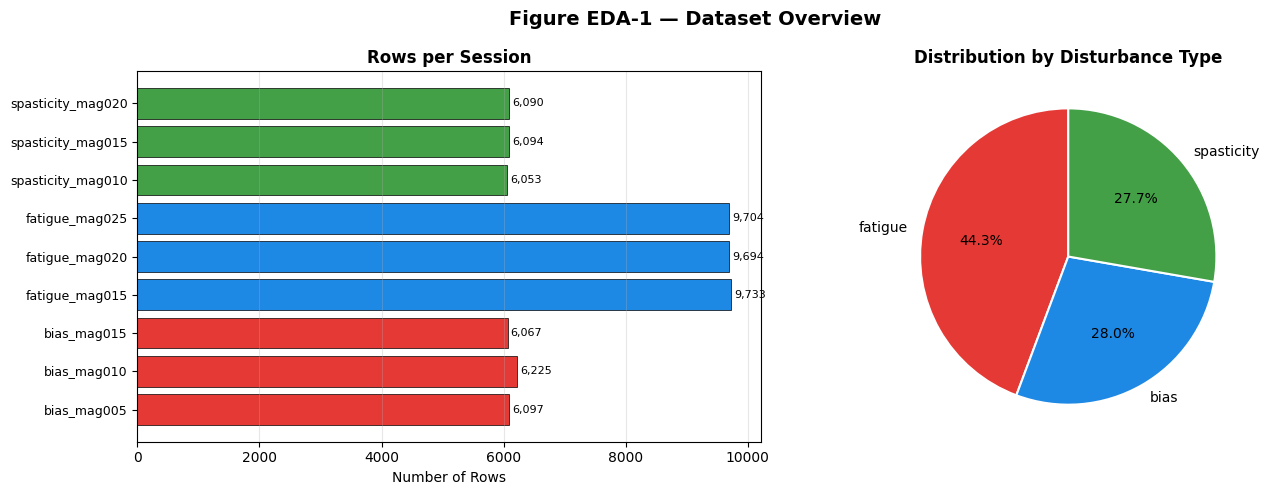

Saved: eda_fig1_dataset_overview.png


In [5]:
# ============================================================
# CELL 5 — EDA Figure 1: Row distribution across sessions
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure EDA-1 — Dataset Overview', fontsize=14, fontweight='bold')

# Left: rows per session
session_counts = raw['session'].value_counts().sort_index()
colors_session = (
    ['#E53935'] * 3 +   # spasticity — red
    ['#1E88E5'] * 3 +   # bias       — blue
    ['#43A047'] * 3     # fatigue    — green
)
bars = axes[0].barh(range(len(session_counts)), session_counts.values,
                    color=colors_session, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(range(len(session_counts)))
axes[0].set_yticklabels(session_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Rows', fontsize=10)
axes[0].set_title('Rows per Session', fontweight='bold')
axes[0].grid(True, axis='x', alpha=0.3)
for bar, val in zip(bars, session_counts.values):
    axes[0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
                 f'{val:,}', va='center', fontsize=8)

# Right: rows per disturbance type (pie)
type_counts = raw['disturbance_type'].value_counts()
axes[1].pie(type_counts.values,
            labels=type_counts.index,
            autopct='%1.1f%%',
            colors=['#E53935', '#1E88E5', '#43A047'],
            startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
axes[1].set_title('Distribution by Disturbance Type', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_fig1_dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: eda_fig1_dataset_overview.png")

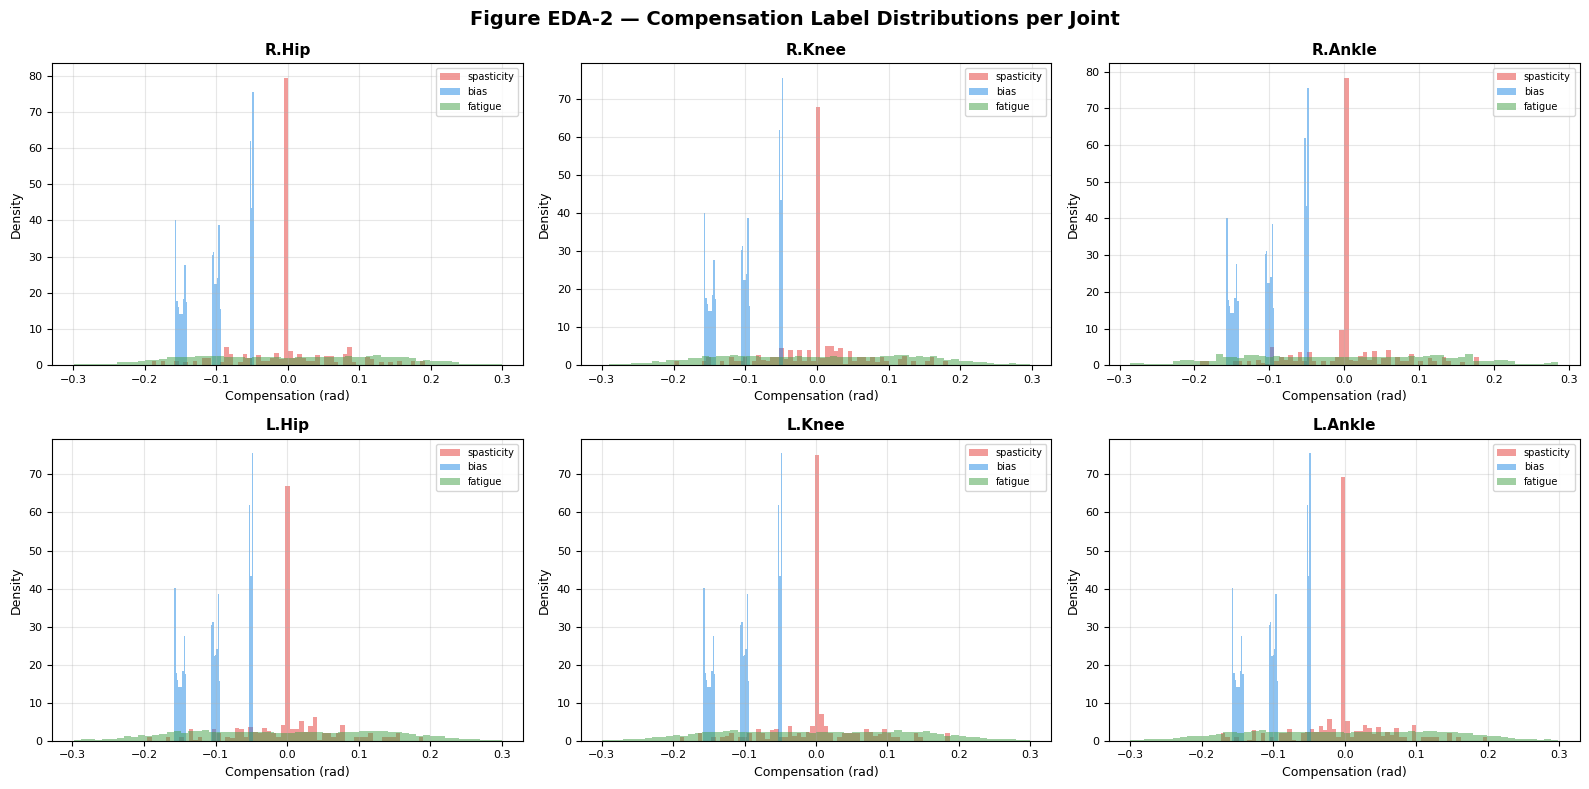

Saved: eda_fig2_label_distributions.png


In [6]:
# ============================================================
# CELL 6 — EDA Figure 2: Compensation (label) distributions
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Figure EDA-2 — Compensation Label Distributions per Joint',
             fontsize=14, fontweight='bold')

colors = ['#E53935', '#FB8C00', '#FDD835', '#1E88E5', '#00ACC1', '#43A047']

for i, (ax, label_col, jlabel) in enumerate(zip(axes.flatten(), LABEL_COLS, JOINT_LABELS)):
    for dtype, color, ls in zip(
        ['spasticity', 'bias', 'fatigue'],
        ['#E53935', '#1E88E5', '#43A047'],
        ['-', '--', '-.']
    ):
        subset = raw[raw['disturbance_type'] == dtype][label_col]
        ax.hist(subset, bins=60, alpha=0.5, color=color,
                label=dtype, edgecolor='none', density=True)

    ax.set_title(jlabel, fontsize=11, fontweight='bold')
    ax.set_xlabel('Compensation (rad)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('eda_fig2_label_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: eda_fig2_label_distributions.png")

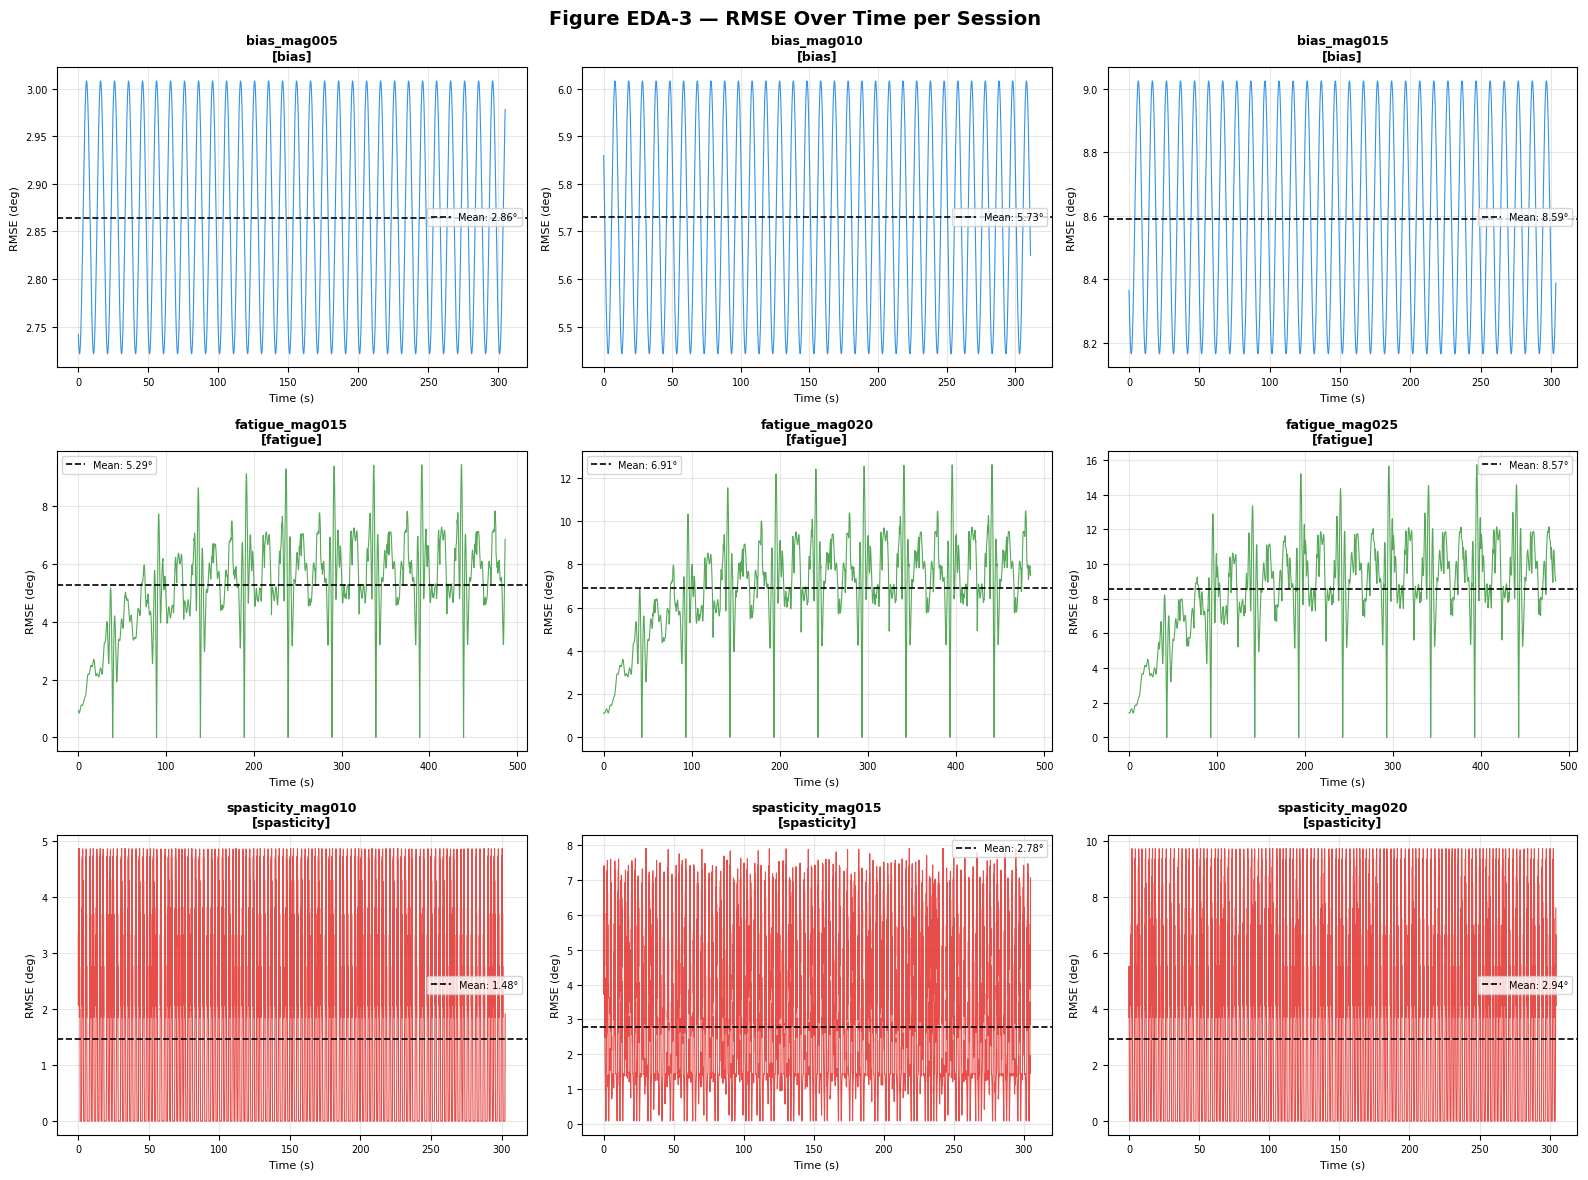

Saved: eda_fig3_rmse_per_session.png


In [7]:
# ============================================================
# CELL 7 — EDA Figure 3: RMSE over time per session
# ============================================================

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Figure EDA-3 — RMSE Over Time per Session',
             fontsize=14, fontweight='bold')

sessions = sorted(raw['session'].unique())
type_colors = {'spasticity': '#E53935', 'bias': '#1E88E5', 'fatigue': '#43A047'}

for ax, session in zip(axes.flatten(), sessions):
    subset = raw[raw['session'] == session].reset_index(drop=True)
    dtype  = subset['disturbance_type'].iloc[0]
    color  = type_colors[dtype]

    ax.plot(subset['time_sec'], np.degrees(subset['rmse']),
            color=color, linewidth=0.8, alpha=0.9)
    ax.axhline(np.degrees(subset['rmse'].mean()), color='black',
               linewidth=1.2, linestyle='--',
               label=f"Mean: {np.degrees(subset['rmse'].mean()):.2f}°")
    ax.set_title(f'{session}\n[{dtype}]', fontsize=9, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=8)
    ax.set_ylabel('RMSE (deg)', fontsize=8)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig('eda_fig3_rmse_per_session.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: eda_fig3_rmse_per_session.png")

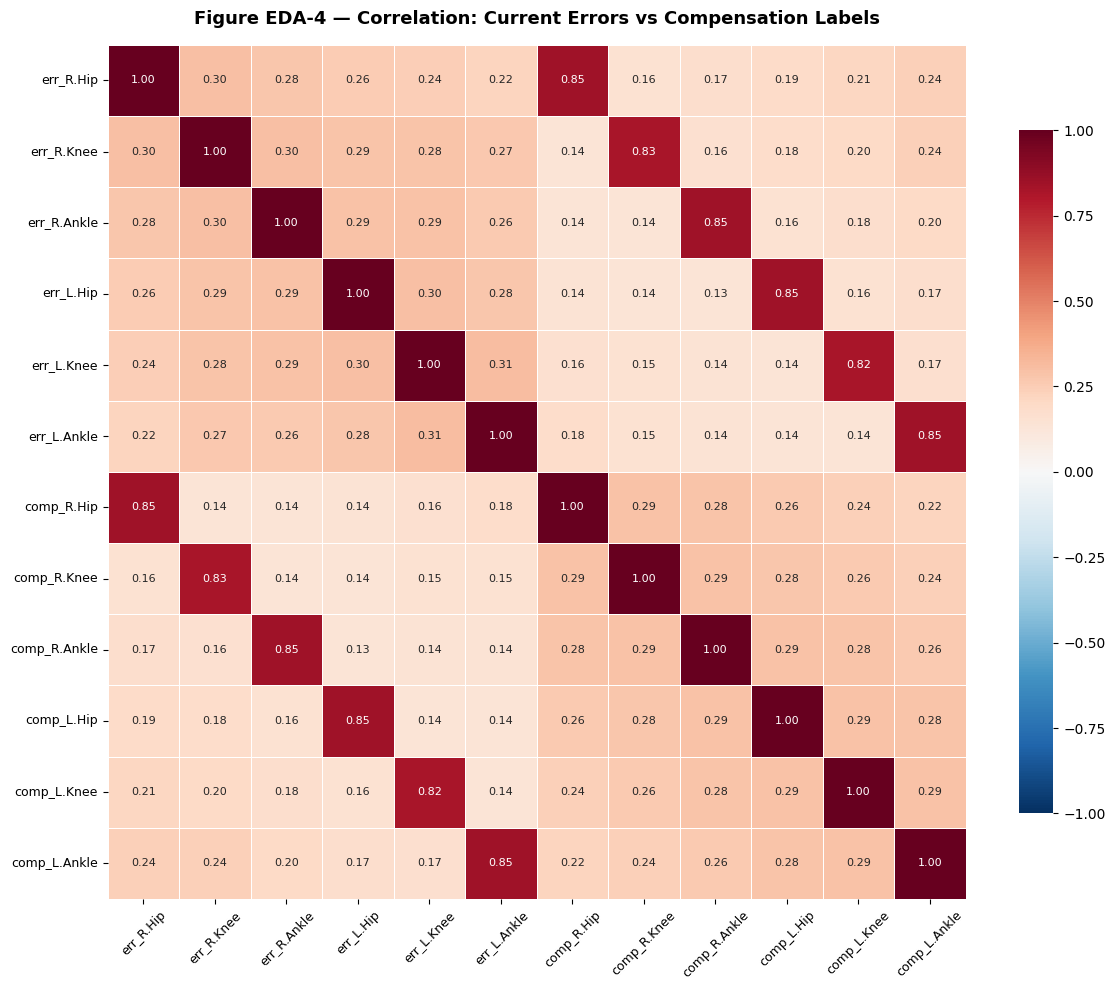

Saved: eda_fig4_correlation_heatmap.png


In [8]:
# ============================================================
# CELL 8 — EDA Figure 4: Correlation heatmap (current errors vs labels)
# ============================================================

# Use only the most recent error (t-0) vs compensation for clarity
current_error_cols = [f'error_{n}_tminus0' for n in JOINT_NAMES]

corr_data = raw[current_error_cols + LABEL_COLS].copy()
corr_data.columns = (
    [f'err_{jl}' for jl in JOINT_LABELS] +
    [f'comp_{jl}' for jl in JOINT_LABELS]
)

fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = corr_data.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)

sns.heatmap(corr_matrix,
            ax=ax,
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            annot=True, fmt='.2f',
            annot_kws={'size': 8},
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'shrink': 0.8})

ax.set_title('Figure EDA-4 — Correlation: Current Errors vs Compensation Labels',
             fontsize=13, fontweight='bold', pad=15)
ax.tick_params(axis='x', rotation=45, labelsize=9)
ax.tick_params(axis='y', rotation=0,  labelsize=9)

plt.tight_layout()
plt.savefig('eda_fig4_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: eda_fig4_correlation_heatmap.png")

In [9]:
# ============================================================
# CELL 9 — Preprocessing: clean, normalize, split
# ============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows where all compensation labels are zero
# (these are inter-burst silences from spasticity — keep some but not all)
label_array = raw[LABEL_COLS].values
nonzero_mask = ~(np.abs(label_array).sum(axis=1) == 0)
zero_mask    = (np.abs(label_array).sum(axis=1) == 0)

# Keep all non-zero rows + 30% of zero rows (to teach "no disturbance = no compensation")
nonzero_df = raw[nonzero_mask]
zero_df    = raw[zero_mask].sample(frac=0.3, random_state=42)
data       = pd.concat([nonzero_df, zero_df], ignore_index=True).sample(
    frac=1, random_state=42
).reset_index(drop=True)

print(f"After cleaning:")
print(f"  Non-zero rows kept  : {len(nonzero_df):,}")
print(f"  Zero rows kept (30%): {len(zero_df):,}")
print(f"  Total training data : {len(data):,}")

# Extract features and labels
X = data[FEATURE_COLS].values.astype(np.float32)
y = data[LABEL_COLS].values.astype(np.float32)

# Normalize features (StandardScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train / Val / Test split: 70% / 15% / 15%
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42   # 0.1765 * 0.85 ≈ 0.15
)

print(f"\nTrain : {X_train.shape[0]:,} samples")
print(f"Val   : {X_val.shape[0]:,} samples")
print(f"Test  : {X_test.shape[0]:,} samples")
print(f"Feature dim: {X_train.shape[1]}")
print(f"Label dim  : {y_train.shape[1]}")

# Save scalers for later use in the ROS2 node
import pickle
with open('scaler_X.pkl', 'wb') as f: pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f: pickle.dump(scaler_y, f)
print("\nScalers saved: scaler_X.pkl, scaler_y.pkl")

After cleaning:
  Non-zero rows kept  : 58,074
  Zero rows kept (30%): 2,305
  Total training data : 60,379

Train : 42,263 samples
Val   : 9,059 samples
Test  : 9,057 samples
Feature dim: 187
Label dim  : 6

Scalers saved: scaler_X.pkl, scaler_y.pkl


In [10]:
# ============================================================
# CELL 10 — Build PyTorch Dataset and DataLoader
# ============================================================

import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

class RDCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 256

train_loader = DataLoader(RDCDataset(X_train, y_train),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(RDCDataset(X_val,   y_val),
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(RDCDataset(X_test,  y_test),
                          batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")

Training on: cuda
Train batches : 166
Val batches   : 36
Test batches  : 36


In [11]:
# ============================================================
# CELL 11 — Define LSTM Model
# ============================================================

import torch.nn as nn

class LSTMResidualCompensator(nn.Module):
    """
    LSTM-based Residual Dynamics Compensator.

    Architecture:
      Input (187) → FC projection → LSTM (2 layers, 128 hidden)
                 → Dropout → FC → FC → Output (6)

    The FC projection reduces input dim before the LSTM,
    which improves convergence and reduces overfitting.
    """
    def __init__(self,
                 input_dim=67,
                 hidden_dim=128,
                 num_layers=2,
                 output_dim=6,
                 dropout=0.2):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Project flat input into a smaller embedding before LSTM
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # LSTM core
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Output head
        self.output_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # x shape: (batch, features)
        # Project and add sequence dim of 1 for LSTM
        x = self.input_proj(x)            # (batch, 64)
        x = x.unsqueeze(1)                # (batch, 1, 64)
        out, _ = self.lstm(x)             # (batch, 1, hidden)
        out = out[:, -1, :]               # (batch, hidden)
        return self.output_head(out)      # (batch, 6)


model = LSTMResidualCompensator(
    input_dim=187,   # ← was 67
    hidden_dim=128,
    num_layers=2,
    output_dim=6,
    dropout=0.2
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTotal trainable parameters: {total_params:,}")

LSTMResidualCompensator(
  (input_proj): Sequential(
    (0): Linear(in_features=187, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (output_head): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

Total trainable parameters: 252,102


In [12]:
# ============================================================
# CELL 12 — Train the LSTM
# ============================================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS   = 200
LR       = 1e-3
PATIENCE = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses  = []
val_losses    = []
best_val_loss = float('inf')
patience_counter = 0

print(f"Training for up to {EPOCHS} epochs (early stop patience={PATIENCE})...\n")

for epoch in range(1, EPOCHS + 1):
    # ── Train ──────────────────────────────────────────────
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ── Validate ───────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            val_loss += criterion(model(X_batch), y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    # ── Early stopping ─────────────────────────────────────
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'rdc_lstm_best.pt')
    else:
        patience_counter += 1

    # ── Print every 10 epochs ──────────────────────────────
    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or patience_counter == PATIENCE:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"Train: {train_loss:.6f} | "
              f"Val: {val_loss:.6f} | "
              f"Best: {best_val_loss:.6f} | "
              f"LR: {current_lr:.6f} | "
              f"Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}.")
        break

print(f"\nBest model saved: rdc_lstm_best.pt")
print(f"Best validation loss: {best_val_loss:.6f}")

Training for up to 200 epochs (early stop patience=10)...

Epoch  10/200 | Train: 0.041516 | Val: 0.014206 | Best: 0.014206 | LR: 0.001000 | Patience: 0/10
Epoch  20/200 | Train: 0.029873 | Val: 0.007829 | Best: 0.007829 | LR: 0.001000 | Patience: 0/10
Epoch  30/200 | Train: 0.025900 | Val: 0.009008 | Best: 0.007392 | LR: 0.001000 | Patience: 4/10
Epoch  40/200 | Train: 0.022171 | Val: 0.006853 | Best: 0.006313 | LR: 0.000250 | Patience: 7/10
Epoch  50/200 | Train: 0.020867 | Val: 0.006832 | Best: 0.006210 | LR: 0.000125 | Patience: 8/10
Epoch  52/200 | Train: 0.020746 | Val: 0.007004 | Best: 0.006210 | LR: 0.000125 | Patience: 10/10

Early stopping at epoch 52.

Best model saved: rdc_lstm_best.pt
Best validation loss: 0.006210


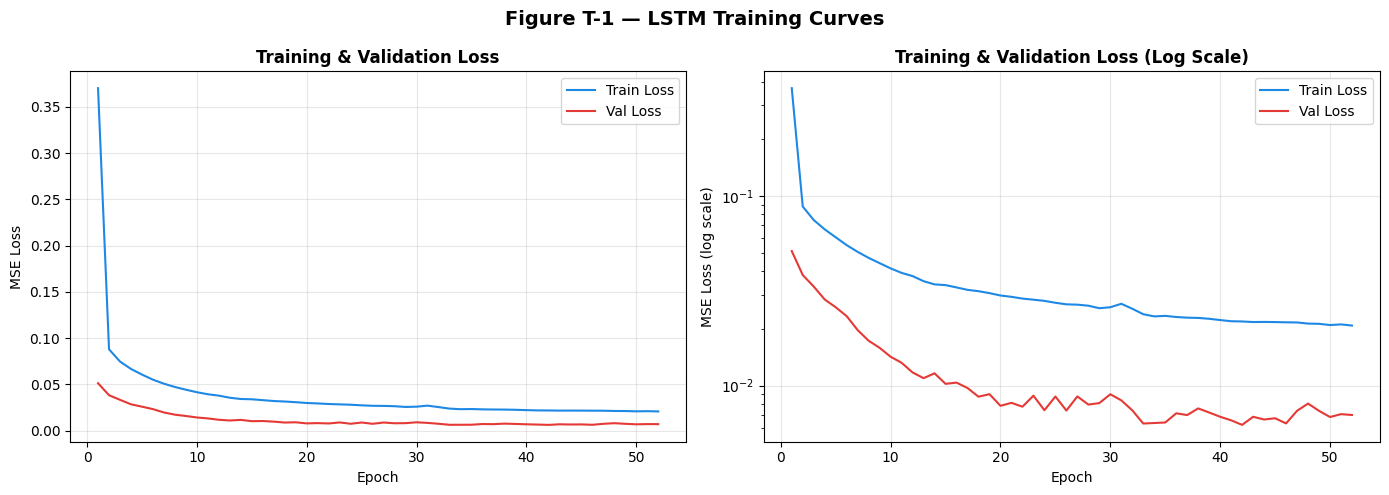

Saved: fig_T1_training_curves.png


In [13]:
# ============================================================
# CELL 13 — Training Figure: Loss curves
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure T-1 — LSTM Training Curves', fontsize=14, fontweight='bold')

epochs_ran = range(1, len(train_losses) + 1)

# Left: raw loss
axes[0].plot(epochs_ran, train_losses, color='#1E88E5', linewidth=1.5, label='Train Loss')
axes[0].plot(epochs_ran, val_losses,   color='#E53935', linewidth=1.5, label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=10)
axes[0].set_ylabel('MSE Loss', fontsize=10)
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: log scale (reveals fine-grained convergence)
axes[1].semilogy(epochs_ran, train_losses, color='#1E88E5', linewidth=1.5, label='Train Loss')
axes[1].semilogy(epochs_ran, val_losses,   color='#E53935', linewidth=1.5, label='Val Loss')
axes[1].set_xlabel('Epoch', fontsize=10)
axes[1].set_ylabel('MSE Loss (log scale)', fontsize=10)
axes[1].set_title('Training & Validation Loss (Log Scale)', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_T1_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_T1_training_curves.png")

In [14]:
# ============================================================
# CELL 14 — Train GPR Baseline
# ============================================================

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')

# GPR is slow on large data — subsample for training
GPR_TRAIN_SIZE = 3000
idx = np.random.choice(len(X_train), GPR_TRAIN_SIZE, replace=False)
X_gpr_train = X_train[idx]
y_gpr_train = y_train[idx]

print(f"Training GPR on {GPR_TRAIN_SIZE} samples (subsampled)...")

kernel = Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=0.1)

gpr_base = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=2,
    normalize_y=True,
    random_state=42
)
gpr = MultiOutputRegressor(gpr_base, n_jobs=-1)
gpr.fit(X_gpr_train, y_gpr_train)

print("GPR training complete.")

# Evaluate on test set (subsample for speed)
gpr_test_size = min(1000, len(X_test))
idx_test = np.random.choice(len(X_test), gpr_test_size, replace=False)
X_gpr_test = X_test[idx_test]
y_gpr_test = y_test[idx_test]

y_gpr_pred_scaled = gpr.predict(X_gpr_test)
y_gpr_pred = scaler_y.inverse_transform(y_gpr_pred_scaled)
y_gpr_true = scaler_y.inverse_transform(y_gpr_test)

gpr_rmse_per_joint = np.sqrt(np.mean((y_gpr_pred - y_gpr_true) ** 2, axis=0))
gpr_mae_per_joint  = np.mean(np.abs(y_gpr_pred - y_gpr_true), axis=0)
print(f"\nGPR Test RMSE per joint (rad): {gpr_rmse_per_joint.round(6)}")
print(f"GPR Test MAE  per joint (rad): {gpr_mae_per_joint.round(6)}")

import pickle
with open('rdc_gpr_model.pkl', 'wb') as f:
    pickle.dump(gpr, f)
print("\nGPR model saved: rdc_gpr_model.pkl")

Training GPR on 3000 samples (subsampled)...
GPR training complete.

GPR Test RMSE per joint (rad): [0.009921 0.009825 0.009852 0.009921 0.010084 0.009655]
GPR Test MAE  per joint (rad): [0.003441 0.003399 0.003173 0.003222 0.003466 0.003218]

GPR model saved: rdc_gpr_model.pkl


In [15]:
# ============================================================
# CELL 15 — LSTM Test set evaluation
# ============================================================

# Load best model
model.load_state_dict(torch.load('rdc_lstm_best.pt', map_location=DEVICE))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        pred = model(X_batch).cpu().numpy()
        all_preds.append(pred)
        all_true.append(y_batch.numpy())

y_pred_scaled = np.vstack(all_preds)
y_true_scaled = np.vstack(all_true)

# Inverse transform to original scale (radians)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

lstm_rmse_per_joint = np.sqrt(np.mean((y_pred - y_true) ** 2, axis=0))
lstm_mae_per_joint  = np.mean(np.abs(y_pred - y_true), axis=0)
lstm_rmse_overall   = np.sqrt(np.mean((y_pred - y_true) ** 2))
lstm_mae_overall    = np.mean(np.abs(y_pred - y_true))

print("=" * 60)
print("  LSTM TEST SET RESULTS")
print("=" * 60)
print(f"  {'Joint':<20} {'RMSE (rad)':>12} {'MAE (rad)':>12}")
print("  " + "-" * 46)
for i, jl in enumerate(JOINT_LABELS):
    print(f"  {jl:<20} {lstm_rmse_per_joint[i]:>12.6f} {lstm_mae_per_joint[i]:>12.6f}")
print("  " + "-" * 46)
print(f"  {'OVERALL':<20} {lstm_rmse_overall:>12.6f} {lstm_mae_overall:>12.6f}")
print("=" * 60)

  LSTM TEST SET RESULTS
  Joint                  RMSE (rad)    MAE (rad)
  ----------------------------------------------
  R.Hip                    0.008933     0.006016
  R.Knee                   0.008054     0.005472
  R.Ankle                  0.008022     0.005415
  L.Hip                    0.008449     0.005686
  L.Knee                   0.008977     0.006049
  L.Ankle                  0.009155     0.006006
  ----------------------------------------------
  OVERALL                  0.008610     0.005774


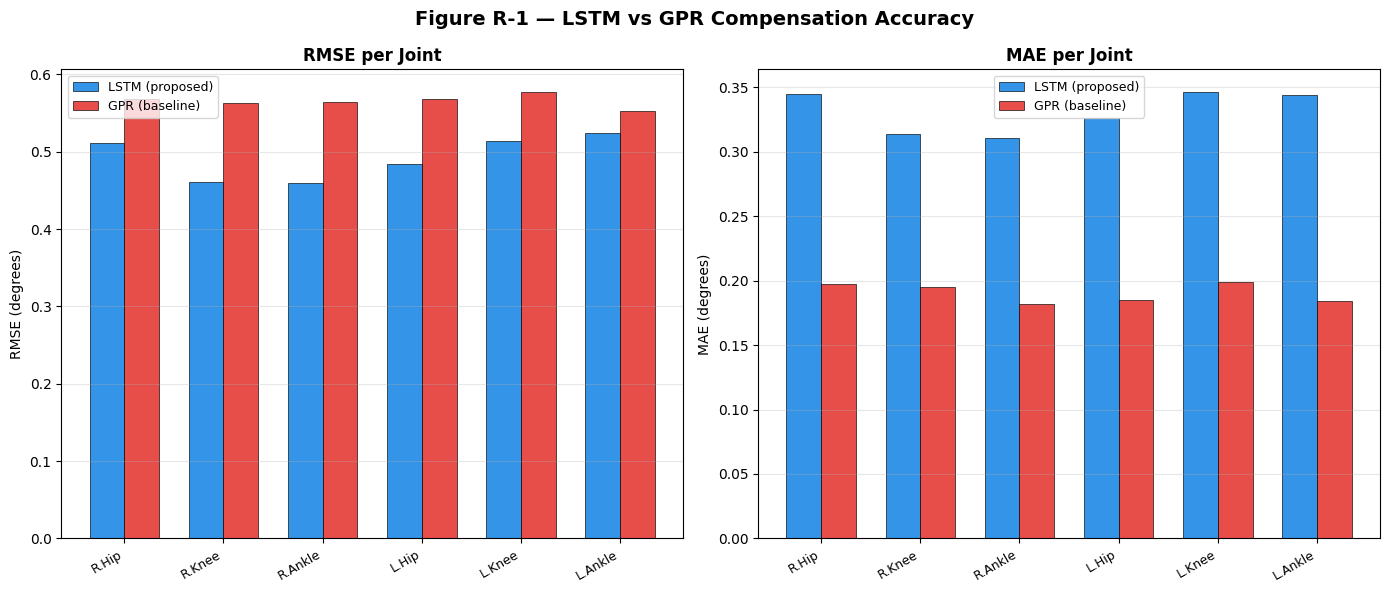

Saved: fig_R1_lstm_vs_gpr.png


In [16]:
# ============================================================
# CELL 16 — Results Figure 1: LSTM vs GPR RMSE comparison
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Figure R-1 — LSTM vs GPR Compensation Accuracy',
             fontsize=14, fontweight='bold')

x = np.arange(NUM_JOINTS)
width = 0.35

# Left: RMSE per joint
axes[0].bar(x - width/2, np.degrees(lstm_rmse_per_joint),
            width, label='LSTM (proposed)', color='#1E88E5',
            edgecolor='black', linewidth=0.5, alpha=0.9)
axes[0].bar(x + width/2, np.degrees(gpr_rmse_per_joint),
            width, label='GPR (baseline)', color='#E53935',
            edgecolor='black', linewidth=0.5, alpha=0.9)
axes[0].set_xticks(x)
axes[0].set_xticklabels(JOINT_LABELS, rotation=30, ha='right', fontsize=9)
axes[0].set_ylabel('RMSE (degrees)', fontsize=10)
axes[0].set_title('RMSE per Joint', fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, axis='y', alpha=0.3)

# Right: MAE per joint
axes[1].bar(x - width/2, np.degrees(lstm_mae_per_joint),
            width, label='LSTM (proposed)', color='#1E88E5',
            edgecolor='black', linewidth=0.5, alpha=0.9)
axes[1].bar(x + width/2, np.degrees(gpr_mae_per_joint),
            width, label='GPR (baseline)', color='#E53935',
            edgecolor='black', linewidth=0.5, alpha=0.9)
axes[1].set_xticks(x)
axes[1].set_xticklabels(JOINT_LABELS, rotation=30, ha='right', fontsize=9)
axes[1].set_ylabel('MAE (degrees)', fontsize=10)
axes[1].set_title('MAE per Joint', fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_R1_lstm_vs_gpr.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R1_lstm_vs_gpr.png")

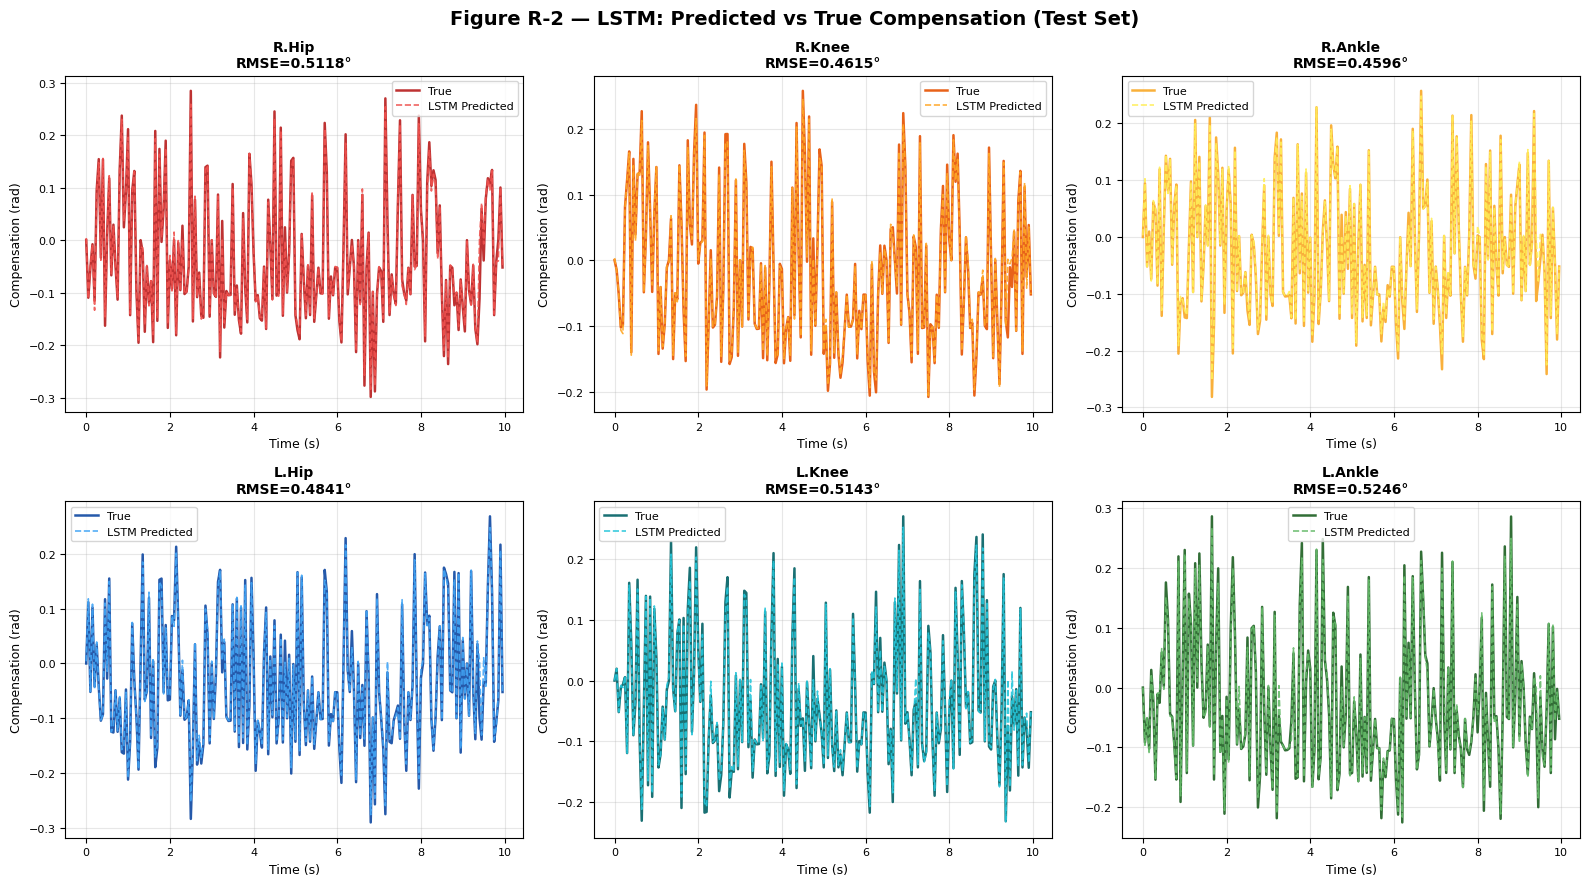

Saved: fig_R2_predicted_vs_true.png


In [17]:
# ============================================================
# CELL 17 — Results Figure 2: Predicted vs True compensation (all 6 joints)
# ============================================================

# Use a 200-sample window for clarity
N_PLOT = 200
t_axis = np.arange(N_PLOT) * 0.05  # 20 Hz → 0.05s steps

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Figure R-2 — LSTM: Predicted vs True Compensation (Test Set)',
             fontsize=14, fontweight='bold')

colors_true = ['#B71C1C', '#E65100', '#F9A825', '#0D47A1', '#006064', '#1B5E20']
colors_pred = ['#EF5350', '#FFA726', '#FFEE58', '#42A5F5', '#26C6DA', '#66BB6A']

for i, ax in enumerate(axes.flatten()):
    ax.plot(t_axis, y_true[:N_PLOT, i],
            color=colors_true[i], linewidth=1.8, linestyle='-',
            label='True', alpha=0.9)
    ax.plot(t_axis, y_pred[:N_PLOT, i],
            color=colors_pred[i], linewidth=1.2, linestyle='--',
            label='LSTM Predicted', alpha=0.9)
    ax.set_title(f'{JOINT_LABELS[i]}\nRMSE={np.degrees(lstm_rmse_per_joint[i]):.4f}°',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Compensation (rad)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('fig_R2_predicted_vs_true.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R2_predicted_vs_true.png")

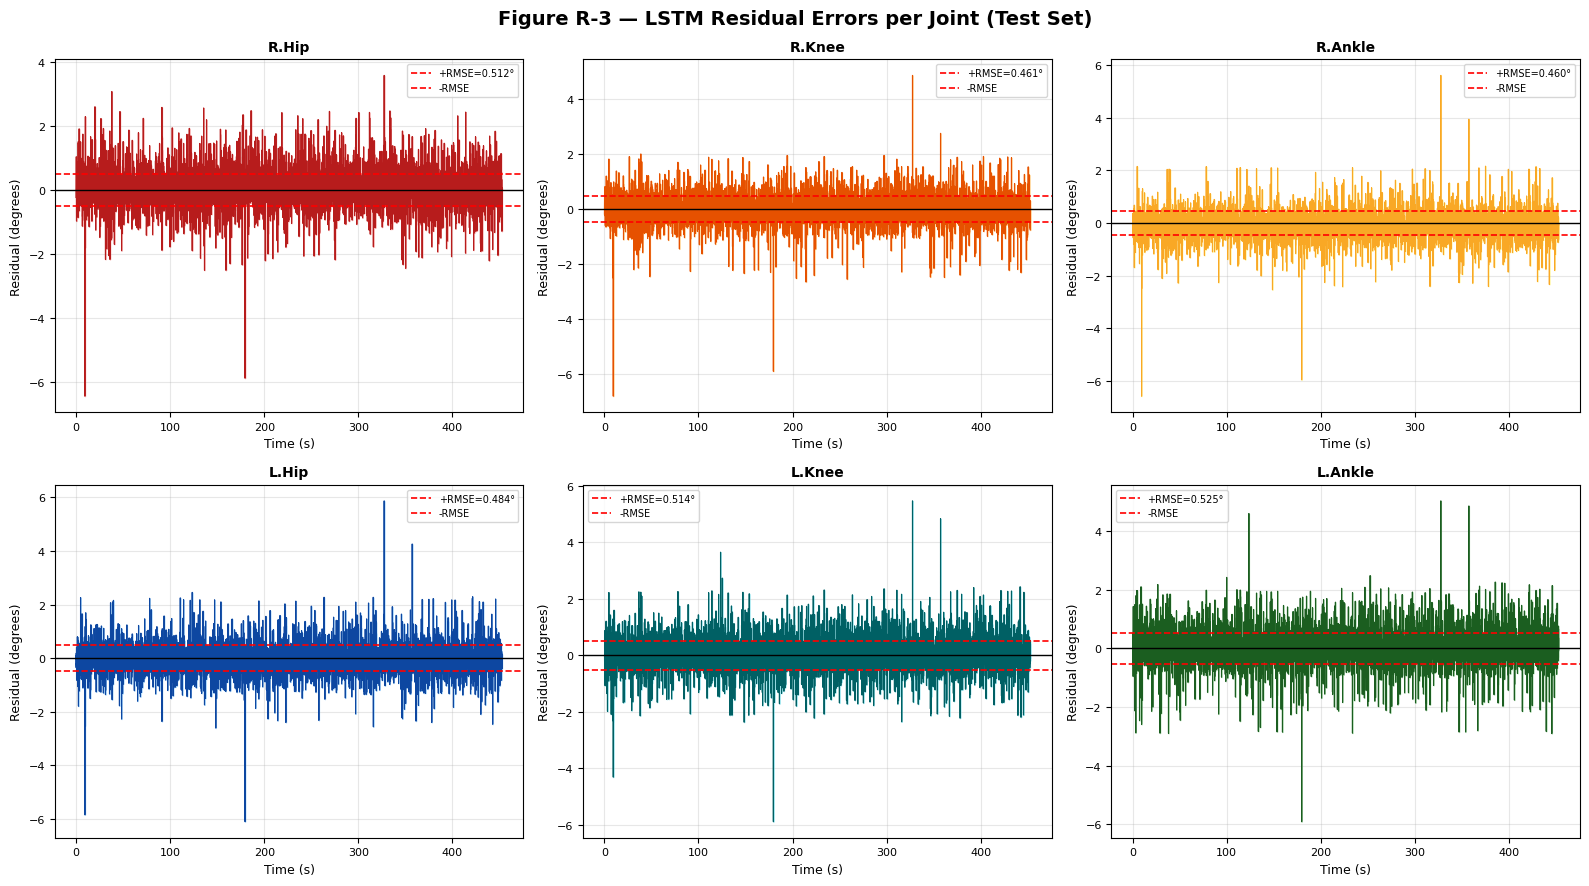

Saved: fig_R3_residual_errors.png


In [18]:
# ============================================================
# CELL 18 — Results Figure 3: Residual errors (True - Predicted)
# ============================================================

residuals = y_true - y_pred

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Figure R-3 — LSTM Residual Errors per Joint (Test Set)',
             fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    res_deg = np.degrees(residuals[:, i])
    ax.fill_between(np.arange(len(res_deg)) * 0.05, res_deg,
                    alpha=0.4, color=colors_pred[i])
    ax.plot(np.arange(len(res_deg)) * 0.05, res_deg,
            color=colors_true[i], linewidth=0.8)
    ax.axhline(0, color='black', linewidth=1.0, linestyle='-')
    ax.axhline(np.degrees(lstm_rmse_per_joint[i]),  color='red',
               linewidth=1.2, linestyle='--', label=f'+RMSE={np.degrees(lstm_rmse_per_joint[i]):.3f}°')
    ax.axhline(-np.degrees(lstm_rmse_per_joint[i]), color='red',
               linewidth=1.2, linestyle='--', label=f'-RMSE')
    ax.set_title(f'{JOINT_LABELS[i]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Residual (degrees)', fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('fig_R3_residual_errors.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R3_residual_errors.png")

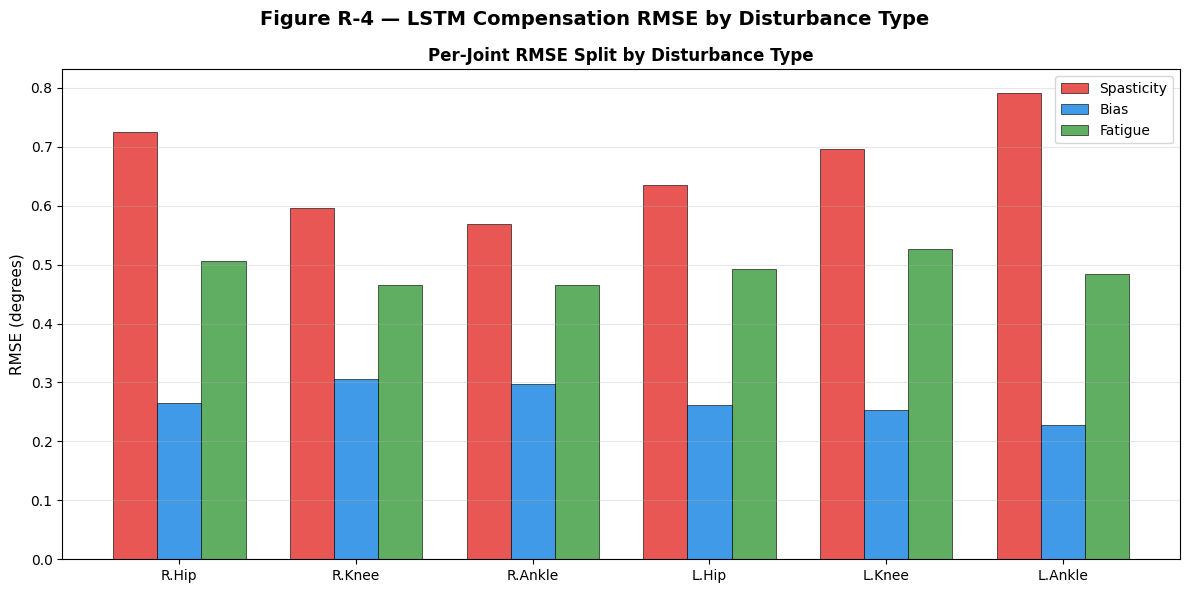

Saved: fig_R4_rmse_by_type.png


In [19]:
# ============================================================
# CELL 19 — Results Figure 4: Performance by disturbance type
# ============================================================

# Re-run inference on full test data tagged by disturbance type
# We need to preserve the type info — rebuild test set with tags
data_test_idx = data.index[
    np.isin(np.arange(len(data)),
            np.where(np.isin(np.arange(len(X_scaled)),
                     np.arange(len(X_scaled))[-len(X_test):]))[0])
]

# Simpler approach: infer on all data and compare by type
all_X = scaler_X.transform(data[FEATURE_COLS].values.astype(np.float32))
all_y = data[LABEL_COLS].values.astype(np.float32)

model.eval()
batch_size = 512
all_preds_full = []
with torch.no_grad():
    for start in range(0, len(all_X), batch_size):
        batch = torch.tensor(all_X[start:start+batch_size], dtype=torch.float32).to(DEVICE)
        all_preds_full.append(model(batch).cpu().numpy())

y_pred_all_scaled = np.vstack(all_preds_full)
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled)
y_true_all = scaler_y.inverse_transform(scaler_y.transform(all_y))

rmse_by_type = {}
for dtype in ['spasticity', 'bias', 'fatigue']:
    mask = data['disturbance_type'].values == dtype
    rmse = np.sqrt(np.mean((y_pred_all[mask] - y_true_all[mask]) ** 2, axis=0))
    rmse_by_type[dtype] = rmse

fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Figure R-4 — LSTM Compensation RMSE by Disturbance Type',
             fontsize=14, fontweight='bold')

x = np.arange(NUM_JOINTS)
width = 0.25
type_colors = {'spasticity': '#E53935', 'bias': '#1E88E5', 'fatigue': '#43A047'}
offsets = [-width, 0, width]

for (dtype, color), offset in zip(type_colors.items(), offsets):
    ax.bar(x + offset, np.degrees(rmse_by_type[dtype]),
           width, label=dtype.capitalize(),
           color=color, edgecolor='black', linewidth=0.5, alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(JOINT_LABELS, fontsize=10)
ax.set_ylabel('RMSE (degrees)', fontsize=11)
ax.set_title('Per-Joint RMSE Split by Disturbance Type', fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_R4_rmse_by_type.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R4_rmse_by_type.png")

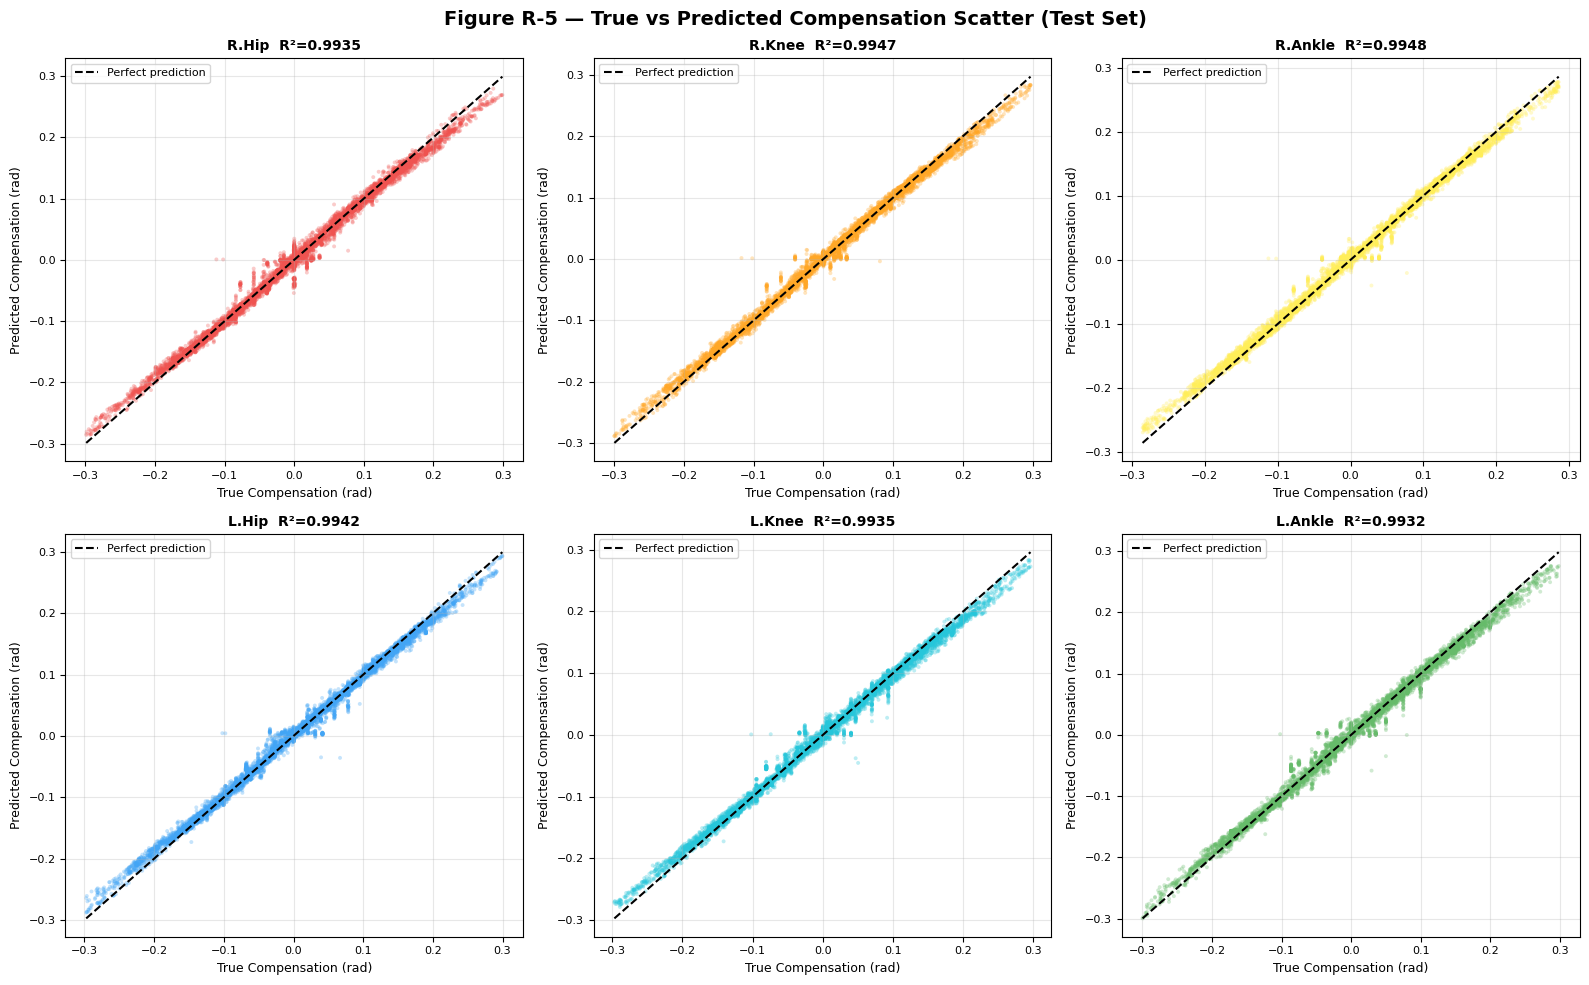

Saved: fig_R5_scatter_true_vs_pred.png


In [20]:
# ============================================================
# CELL 20 — Results Figure 5: Scatter plots (True vs Predicted)
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Figure R-5 — True vs Predicted Compensation Scatter (Test Set)',
             fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    ax.scatter(y_true[:, i], y_pred[:, i],
               alpha=0.3, s=8, color=colors_pred[i], edgecolors='none')

    # Perfect prediction line
    lims = [min(y_true[:, i].min(), y_pred[:, i].min()),
            max(y_true[:, i].max(), y_pred[:, i].max())]
    ax.plot(lims, lims, 'k--', linewidth=1.5, label='Perfect prediction')

    # R² score
    ss_res = np.sum((y_true[:, i] - y_pred[:, i]) ** 2)
    ss_tot = np.sum((y_true[:, i] - y_true[:, i].mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0

    ax.set_title(f'{JOINT_LABELS[i]}  R²={r2:.4f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('True Compensation (rad)', fontsize=9)
    ax.set_ylabel('Predicted Compensation (rad)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('fig_R5_scatter_true_vs_pred.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R5_scatter_true_vs_pred.png")

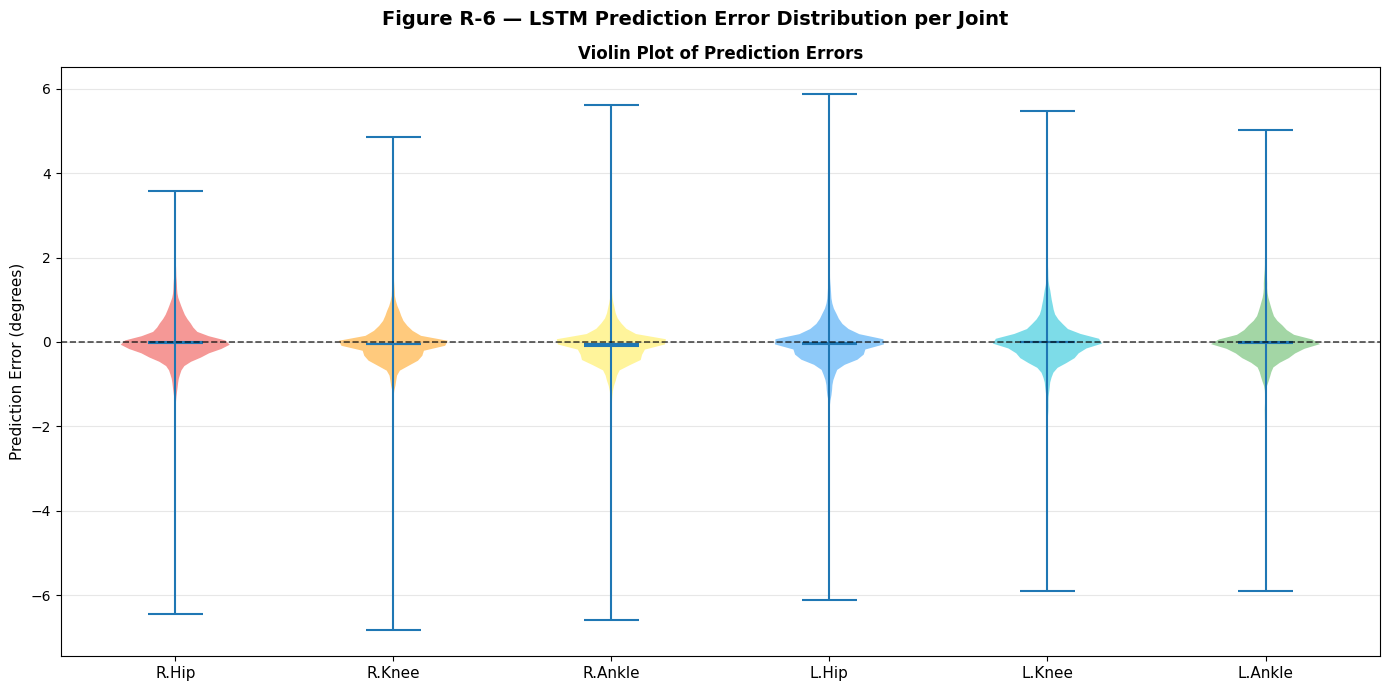

Saved: fig_R6_error_violin.png


In [21]:
# ============================================================
# CELL 21 — Results Figure 6: Error distribution violin plots
# ============================================================

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Figure R-6 — LSTM Prediction Error Distribution per Joint',
             fontsize=14, fontweight='bold')

error_deg_per_joint = [np.degrees(residuals[:, i]) for i in range(NUM_JOINTS)]

parts = ax.violinplot(error_deg_per_joint,
                      positions=range(NUM_JOINTS),
                      showmeans=True,
                      showmedians=True,
                      showextrema=True)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors_pred[i])
    pc.set_alpha(0.6)

ax.set_xticks(range(NUM_JOINTS))
ax.set_xticklabels(JOINT_LABELS, fontsize=11)
ax.set_ylabel('Prediction Error (degrees)', fontsize=11)
ax.set_title('Violin Plot of Prediction Errors', fontweight='bold')
ax.axhline(0, color='black', linewidth=1.2, linestyle='--', alpha=0.7)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_R6_error_violin.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_R6_error_violin.png")

In [22]:
# ============================================================
# CELL 22 — Summary Table (paper-ready)
# ============================================================

print("\n" + "=" * 70)
print("  TABLE I — OFFLINE EVALUATION RESULTS (Test Set)")
print("=" * 70)
print(f"  {'Joint':<14} {'LSTM RMSE':>12} {'LSTM MAE':>12} {'GPR RMSE':>12} {'GPR MAE':>12}")
print(f"  {'':14} {'(degrees)':>12} {'(degrees)':>12} {'(degrees)':>12} {'(degrees)':>12}")
print("  " + "-" * 66)
for i, jl in enumerate(JOINT_LABELS):
    print(f"  {jl:<14} "
          f"{np.degrees(lstm_rmse_per_joint[i]):>12.4f} "
          f"{np.degrees(lstm_mae_per_joint[i]):>12.4f} "
          f"{np.degrees(gpr_rmse_per_joint[i]):>12.4f} "
          f"{np.degrees(gpr_mae_per_joint[i]):>12.4f}")
print("  " + "-" * 66)
print(f"  {'Overall':<14} "
      f"{np.degrees(lstm_rmse_overall):>12.4f} "
      f"{np.degrees(lstm_mae_overall):>12.4f} "
      f"{np.degrees(np.sqrt(np.mean((y_gpr_pred - y_gpr_true)**2))):>12.4f} "
      f"{np.degrees(np.mean(np.abs(y_gpr_pred - y_gpr_true))):>12.4f}")
print("=" * 70)
print("\n  LSTM improvement over GPR:")
improvement = (gpr_rmse_per_joint - lstm_rmse_per_joint) / gpr_rmse_per_joint * 100
for i, jl in enumerate(JOINT_LABELS):
    print(f"    {jl:<14}: {improvement[i]:>+.2f}%")


  TABLE I — OFFLINE EVALUATION RESULTS (Test Set)
  Joint             LSTM RMSE     LSTM MAE     GPR RMSE      GPR MAE
                    (degrees)    (degrees)    (degrees)    (degrees)
  ------------------------------------------------------------------
  R.Hip                0.5118       0.3447       0.5684       0.1972
  R.Knee               0.4615       0.3135       0.5629       0.1948
  R.Ankle              0.4596       0.3103       0.5645       0.1818
  L.Hip                0.4841       0.3258       0.5685       0.1846
  L.Knee               0.5143       0.3466       0.5778       0.1986
  L.Ankle              0.5246       0.3441       0.5532       0.1844
  ------------------------------------------------------------------
  Overall              0.4933       0.3308       0.5659       0.1902

  LSTM improvement over GPR:
    R.Hip         : +9.96%
    R.Knee        : +18.02%
    R.Ankle       : +18.57%
    L.Hip         : +14.84%
    L.Knee        : +10.98%
    L.Ankle       : +